<a href="https://colab.research.google.com/github/DaDosValle/Analise_Preditiva-Machine_Learning-TelecomX/blob/main/Analise_Preditiva_TelecomX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

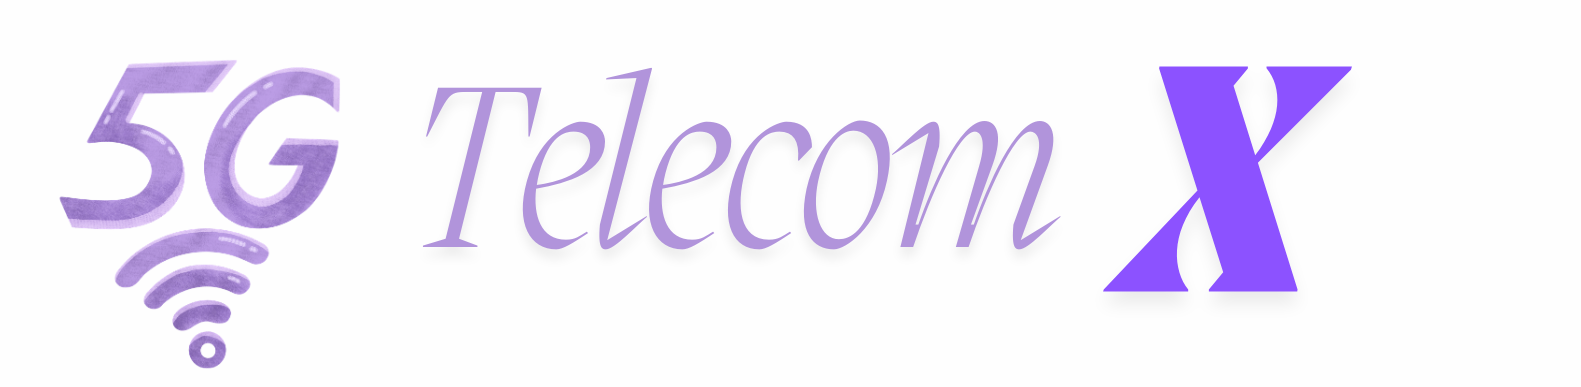

# **Previsão de churn (evasão de clientes) - Aprendizado de máquina**

### **Perguntas SMART**



*   Quem são os clientes com maior risco de evasão?
*   Quais variáveis mais influenciam esse comportameto?
*   Que tipo de perfil a empresa precisa manter mais próximo?



### **01. Importação das Bibliotecas e Visualização Inicial**


In [93]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline

from sklearn.dummy import DummyClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier


from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold, cross_val_score


In [2]:
# Base de dados anteriormente limpa
dados = pd.read_csv('/content/dados_tratados.csv')

In [3]:
dados.head()

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,servico internet,suporte tecnico,streaming tv,streaming filmes,contrato conta,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade,churn_label
0,0,Feminino,0,1,1,9,1,0,DSL,1,1,0,Um ano,2.2,65.6,593.3,527.7,Permaneceram
1,0,Masculino,0,0,0,9,1,1,DSL,0,0,1,Mensal,2.0,59.9,542.4,482.5,Permaneceram
2,1,Masculino,0,0,0,4,1,0,Fibra optica,0,0,0,Mensal,2.5,73.9,280.8,207.0,Saíram
3,1,Masculino,1,1,0,13,1,0,Fibra optica,0,1,1,Mensal,3.3,98.0,1237.8,1139.8,Saíram
4,1,Feminino,1,1,0,3,1,0,Fibra optica,1,1,0,Mensal,2.8,83.9,267.4,183.5,Saíram


### **02. Exploração Exploratoria (EDA)**


##### **02.1 Análise Exploratória (Variável Qualitativa)**

In [4]:
dados.shape

(7043, 18)

In [5]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   churn                    7043 non-null   int64  
 1   sexo                     7043 non-null   object 
 2   idoso                    7043 non-null   int64  
 3   possui parceiro          7043 non-null   int64  
 4   possui dependentes       7043 non-null   int64  
 5   tempo contrato           7043 non-null   int64  
 6   servico telefone         7043 non-null   int64  
 7   multiplas linhas         7043 non-null   int64  
 8   servico internet         7043 non-null   object 
 9   suporte tecnico          7043 non-null   int64  
 10  streaming tv             7043 non-null   int64  
 11  streaming filmes         7043 non-null   int64  
 12  contrato conta           7043 non-null   object 
 13  preco diario             7043 non-null   float64
 14  cobrancas mensais       

In [6]:
dados.describe().round(2)

,churn,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,suporte tecnico,streaming tv,streaming filmes,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade
count,7043.00,7043.00,7043.00,7043.00,7043.00,7043.0,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00,7043.00
mean,0.27,0.16,0.48,0.30,32.37,0.9,0.42,0.29,0.38,0.39,2.16,64.76,2284.33,2219.56
std,0.44,0.37,0.50,0.46,24.56,0.3,0.49,0.45,0.49,0.49,1.00,30.09,2265.95,2246.51
min,0.00,0.00,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.60,18.20,18.80,0.00
25%,0.00,0.00,0.00,0.00,9.00,1.0,0.00,0.00,0.00,0.00,1.20,35.50,401.90,355.75
50%,0.00,0.00,0.00,0.00,29.00,1.0,0.00,0.00,0.00,0.00,2.30,70.40,1398.60,1352.20
75%,1.00,0.00,1.00,1.00,55.00,1.0,1.00,1.00,1.00,1.00,3.00,89.80,3801.50,3730.10
max,1.00,1.00,1.00,1.00,72.00,1.0,1.00,1.00,1.00,1.00,4.00,118.80,8684.80,8567.00


In [7]:
dados.describe(include='O')

,sexo,servico internet,contrato conta,churn_label
count,7043,7043,7043,7043
unique,2,3,3,2
top,Masculino,Fibra optica,Mensal,Permaneceram
freq,3555,3096,3875,5174


In [8]:
quadro_contigencia = dados['churn'].value_counts().reset_index()
quadro_contigencia.columns = ['churn', 'fri_abs']
quadro_contigencia['fri_abs_acumulada'] = quadro_contigencia['fri_abs'].cumsum()
quadro_contigencia['fri_rel'] = round(quadro_contigencia['fri_abs'] / quadro_contigencia['fri_abs'].sum() * 100, 2)
quadro_contigencia['fri_rel_acumulada'] = round(quadro_contigencia['fri_rel'].cumsum(), 2)

quadro_contigencia

,churn,fri_abs,fri_abs_acumulada,fri_rel,fri_rel_acumulada
0,0,5174,5174,73.46,73.46
1,1,1869,7043,26.54,100.00


In [9]:
dados['churn_label'] = dados['churn'].map({0: 'Permaneceram', 1: 'Saíram'})
px.pie(dados, names='churn_label', width=700, title='Distribuição da Variável Alvo: churn')

In [10]:
px.histogram(dados, x='churn_label', text_auto=True, color='churn_label',
            width=700, height=500,
            title='Distribuição da Variável Alvo: churn'
            )


In [11]:
px.histogram(dados, x='sexo', text_auto=True, color='churn_label',
            barmode='group', width=700, height=500,
            title='Distribuição da Variável categórica: sexo')


In [12]:
px.histogram(dados, x = 'idoso', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórico: idoso'
             )


In [13]:
px.histogram(dados, x = 'possui parceiro', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Alvo: possui parceiro'
             )

In [14]:
px.histogram(dados, x = 'possui dependentes', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórico: possui dependentes'
             )


In [15]:
px.histogram(dados, x = 'servico telefone', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórico: servico telefone'
             )

In [16]:
px.histogram(dados, x = 'multiplas linhas', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórico: multiplas linhas')


In [17]:
px.histogram(dados, x = 'servico internet', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórico: servico internet')


In [18]:
px.histogram(dados, x = 'suporte tecnico', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórica: suporte tecnico'
             )


In [19]:
px.histogram(dados, x = 'streaming tv', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórica: streaming tv'
             )


In [20]:
px.histogram(dados, x = 'streaming filmes', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórica: streaming filmes'
             )


In [21]:
px.histogram(dados, x = 'contrato conta', text_auto = True, color = 'churn_label',
             barmode = 'group', width=700, height=500,
             title='Distribuição da Variável Categórica: contrato conta'
             )


##### **02.2 Análise Exploratória (Variável Quantitativa)**


In [22]:
px.box(dados, x='tempo contrato', color='churn_label',
             width=700, height=500,
             title='Distribuição da Variável Númércia: tempo contrato'
             )


In [23]:
px.box(dados, x='preco diario', color='churn_label',
             width=700, height=500,
             title='Distribuição da Variável Numérica: preco diario'
             )


In [24]:
px.box(dados, x='cobrancas mensais', color='churn_label',
             width=700, height=500,
             title='Distribuição da Variável Numérica: cobrancas mensais')



In [25]:
px.box(dados, x='total de encargos', color='churn_label',
       width=700, height=500,
       title='Distribuição da Variável Numércia: total de encargos')



In [26]:
px.box(dados, x='excedente a mensalidade', color='churn_label',
             width=700, height=500,
             title='Distribuição da Variável Numércia: excedente a mensalidade')


### **03. Preparacao dos Dados**


In [27]:
dados = pd.get_dummies(dados, columns=[
    'servico internet',
    'contrato conta'
], drop_first=True)

In [28]:
dados['sexo'] = dados['sexo'].map({'Masculino': 1, 'Feminino': 0})

dados['sexo'] = dados['sexo'].astype(int)

In [29]:
colunas = ['servico internet_Fibra optica', 'servico internet_Nao disponivel', 'contrato conta_Mensal', 'contrato conta_Um ano']

dados[colunas] = dados[colunas].astype(int)

In [30]:
dados = dados.drop(['churn_label'], axis=1)

In [31]:
dados.head(3)

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,suporte tecnico,streaming tv,streaming filmes,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade,servico internet_Fibra optica,servico internet_Nao disponivel,contrato conta_Mensal,contrato conta_Um ano
0,0,0,0,1,1,9,1,0,1,1,0,2.2,65.6,593.3,527.7,0,0,0,1
1,0,1,0,0,0,9,1,1,0,0,1,2.0,59.9,542.4,482.5,0,0,1,0
2,1,1,0,0,0,4,1,0,0,0,0,2.5,73.9,280.8,207.0,1,0,1,0


### **04. Análise de Correlação Entre as Variáveis**

In [32]:
dados.corr(numeric_only=True)

,churn,sexo,idoso,possui parceiro,possui dependentes,tempo contrato,servico telefone,multiplas linhas,suporte tecnico,streaming tv,streaming filmes,preco diario,cobrancas mensais,total de encargos,excedente a mensalidade,servico internet_Fibra optica,servico internet_Nao disponivel,contrato conta_Mensal,contrato conta_Um ano
churn,1.000000,-0.008612,0.150889,-0.150448,-0.164221,-0.352229,0.011942,0.040102,-0.164674,0.063228,0.061382,0.192303,0.193355,-0.199616,-0.203934,0.308020,-0.227890,0.405103,-0.177820
sexo,-0.008612,1.000000,-0.001874,-0.001808,0.010517,0.005106,-0.006488,-0.008414,-0.009212,-0.008393,-0.010487,-0.014815,-0.014543,-0.000575,-0.000385,-0.011286,0.006026,-0.003386,0.008026
idoso,0.150889,-0.001874,1.000000,0.016479,-0.211185,0.016567,0.008576,0.142948,-0.060625,0.105378,0.120176,0.219910,0.220139,0.102153,0.100088,0.255338,-0.182742,0.138360,-0.046262
possui parceiro,-0.150448,-0.001808,0.016479,1.000000,0.452676,0.379697,0.017706,0.142057,0.119999,0.124666,0.117412,0.096943,0.096854,0.319327,0.320794,0.000304,0.000615,-0.280865,0.082783
possui dependentes,-0.164221,0.010517,-0.211185,0.452676,1.000000,0.159712,-0.001762,-0.024526,0.063268,-0.016558,-0.039741,-0.114076,-0.113863,0.065200,0.067290,-0.165818,0.139812,-0.231720,0.068368
tempo contrato,-0.352229,0.005106,0.016567,0.379697,0.159712,1.000000,0.008448,0.331941,0.324221,0.279756,0.286111,0.247879,0.247890,0.823814,0.827624,0.019720,-0.039062,-0.645561,0.202570
servico telefone,0.011942,-0.006488,0.008576,0.017706,-0.001762,0.008448,1.000000,0.279690,-0.096340,-0.022574,-0.032959,0.249120,0.247408,0.112423,0.110082,0.289999,0.172209,-0.000742,-0.002791
multiplas linhas,0.040102,-0.008414,0.142948,0.142057,-0.024526,0.331941,0.279690,1.000000,0.100571,0.257152,0.258751,0.489595,0.490422,0.468006,0.465488,0.366083,-0.210564,-0.088203,-0.003794
suporte tecnico,-0.164674,-0.009212,-0.060625,0.119999,0.063268,0.324221,-0.096340,0.100571,1.000000,0.278070,0.279358,0.337628,0.338284,0.432358,0.431568,-0.020492,-0.336298,-0.285241,0.095775
streaming tv,0.063228,-0.008393,0.105378,0.124666,-0.016558,0.279756,-0.022574,0.257152,0.278070,1.000000,0.533094,0.629855,0.629607,0.515585,0.511614,0.329349,-0.415552,-0.112282,0.061612


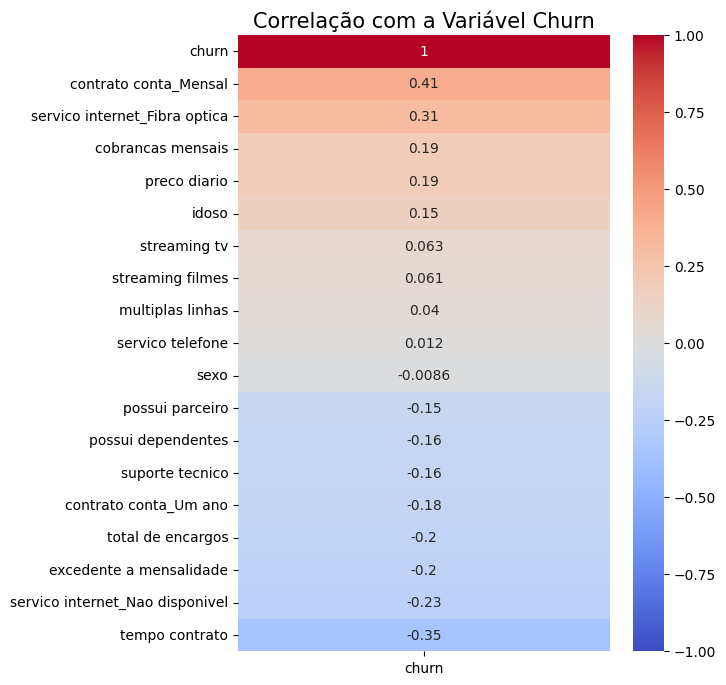

In [33]:
plt.figure(figsize=(6, 8))

# Correlação das variáveis explicativas com a variavel churn
corr_churn = dados.corr(numeric_only=True)[['churn']].sort_values(by='churn', ascending=False)

sns.heatmap(corr_churn, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.title('Correlação com a Variável Churn', fontsize=15)
plt.show()


In [34]:
variaveis_correlacionadas = dados[['tempo contrato','total de encargos','cobrancas mensais']]

variaveis_correlacionadas.corr()

,tempo contrato,total de encargos,cobrancas mensais
tempo contrato,1.000000,0.823814,0.247890
total de encargos,0.823814,1.000000,0.650018
cobrancas mensais,0.247890,0.650018,1.000000


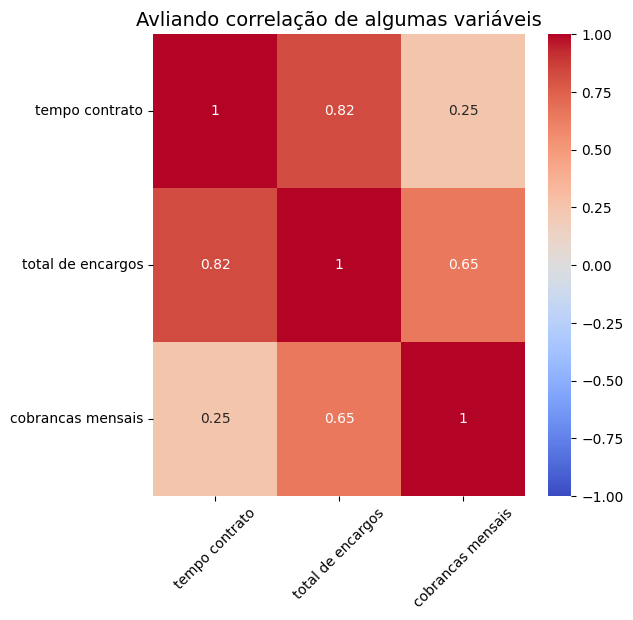

In [35]:
plt.figure(figsize=(6, 6))

# Correlação das variáveis explicativas com a variavel churn
corr_churn_correlacionados = variaveis_correlacionadas.corr(numeric_only=True)

sns.heatmap(corr_churn_correlacionados, annot=True, cmap='coolwarm', vmin=-1, vmax=1)

plt.xticks(rotation=45)
plt.yticks(rotation=0)

plt.title('Avliando correlação de algumas variáveis', fontsize=14)
plt.show()


### **05. Seleção e Separação das Variáveis (Treinamento e Teste)**

In [36]:
# Seleção da variável resposta/alvo

remover_variaveis = ['total de encargos', 'sexo', 'servico telefone', 'streaming tv', 'streaming filmes', 'churn', 'preco diario', 'excedente a mensalidade']

y = dados['churn']

# Seleção das variáveis explicativas
x = dados.drop(remover_variaveis, axis=1)

In [37]:
# Separação dos dados agora para evitar vazamento de dados
x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)

### **06. Modelo de base a Ser Superado**

In [38]:
dummy = DummyClassifier(strategy='stratified', random_state=101)
dummy.fit(x_treino, y_treino)

round(dummy.score(x_teste, y_teste),2)

0.63

In [39]:
y_pred_dummy = dummy.predict(x_teste)

In [40]:
print(classification_report(y_teste, y_pred_dummy))

              precision    recall  f1-score   support

           0       0.74      0.75      0.75      1035
           1       0.29      0.28      0.29       374

    accuracy                           0.63      1409
   macro avg       0.52      0.52      0.52      1409
weighted avg       0.63      0.63      0.63      1409



### **07. Pipeline de Machine Learning e Treinamento**

##### **07.1 Treinando Modelo Regressão Logística**

In [41]:
pipeline = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('smote', SMOTE(random_state=42)),
    ('regressao_log', LogisticRegression(max_iter=1000))
])

In [42]:
pipeline.fit(x_treino, y_treino)

Pipeline(steps=[('scaler', StandardScaler()), ('smote', SMOTE(random_state=42)),
                ('regressao_log', LogisticRegression(max_iter=1000))])

##### **07.2 Avaliando Modelo Regressão Logística**

In [43]:
y_pred = pipeline.predict(x_teste)

print(confusion_matrix(y_teste, y_pred))
print(classification_report(y_teste, y_pred))

[[736 299]
 [ 84 290]]
              precision    recall  f1-score   support

           0       0.90      0.71      0.79      1035
           1       0.49      0.78      0.60       374

    accuracy                           0.73      1409
   macro avg       0.69      0.74      0.70      1409
weighted avg       0.79      0.73      0.74      1409



##### **07.3 Ajuste Para a Métrica Principal (Recall)**

In [44]:
y_proba = pipeline.predict_proba(x_teste)[:,1]

threshold = 0.45
y_pred_custom = (y_proba >= threshold).astype(int)

print(confusion_matrix(y_teste, y_pred_custom))
print(classification_report(y_teste, y_pred_custom))

[[702 333]
 [ 72 302]]
              precision    recall  f1-score   support

           0       0.91      0.68      0.78      1035
           1       0.48      0.81      0.60       374

    accuracy                           0.71      1409
   macro avg       0.69      0.74      0.69      1409
weighted avg       0.79      0.71      0.73      1409



AUC: 0.8328050324214008


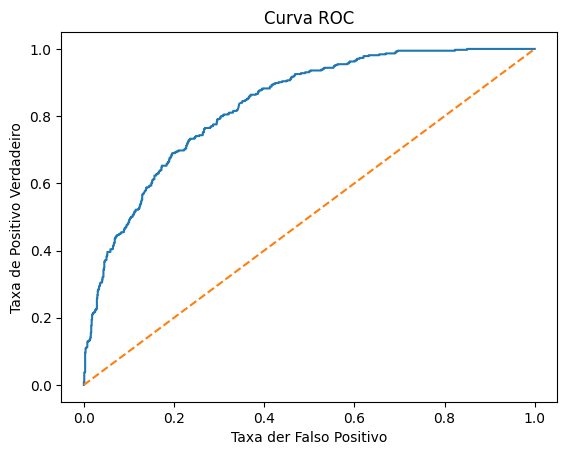

In [45]:
auc = roc_auc_score(y_teste, y_proba)
print("AUC:", auc)

fpr, tpr, thresholds = roc_curve(y_teste, y_proba)

plt.plot(fpr, tpr)
plt.plot([0,1],[0,1],'--')
plt.xlabel("Taxa der Falso Positivo")
plt.ylabel("Taxa de Positivo Verdadeiro")
plt.title("Curva ROC")
plt.show()

### - Análise de importância das variáveis regressão logistica

##### **07.4 Importância das Variáveis do Modelo Regressão Logística**

In [46]:
modelo = pipeline.named_steps['regressao_log']

coeficientes = pd.DataFrame({
    'Variável': x_treino.columns,
    'Coeficiente': modelo.coef_[0]
})

coeficientes['Impacto Absoluto'] = coeficientes['Coeficiente'].abs()

coeficientes = coeficientes.sort_values(
    by='Impacto Absoluto',
    ascending=False
)

coeficientes

,Variável,Coeficiente,Impacto Absoluto
3,tempo contrato,-0.863919,0.863919
9,contrato conta_Mensal,0.815561,0.815561
8,servico internet_Nao disponivel,-0.411161,0.411161
10,contrato conta_Um ano,0.379481,0.379481
7,servico internet_Fibra optica,0.375464,0.375464
5,suporte tecnico,-0.174545,0.174545
6,cobrancas mensais,0.168489,0.168489
4,multiplas linhas,0.139072,0.139072
2,possui dependentes,-0.127689,0.127689
0,idoso,0.111594,0.111594


##### **07.5 Analisando Multicolinearidade**

In [47]:
X = x_treino.copy()

X = sm.add_constant(X)

vif = pd.DataFrame()
vif["Variável"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i)
              for i in range(X.shape[1])]

vif = vif.sort_values(by="VIF", ascending=False)

vif

,Variável,VIF
0,const,49.549866
7,cobrancas mensais,10.383687
8,servico internet_Fibra optica,4.597890
9,servico internet_Nao disponivel,3.746741
10,contrato conta_Mensal,3.420005
4,tempo contrato,2.444577
11,contrato conta_Um ano,1.683432
6,suporte tecnico,1.599320
5,multiplas linhas,1.563274
2,possui parceiro,1.442886


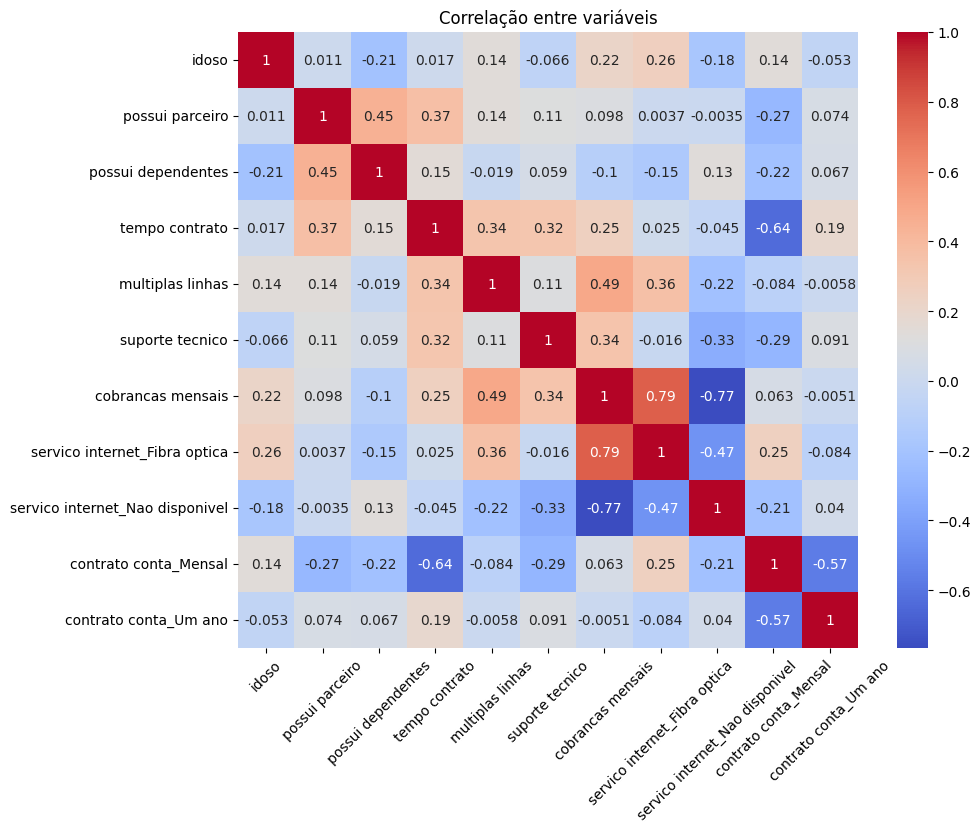

In [48]:
plt.figure(figsize=(10,8))
sns.heatmap(x_treino.corr(), annot=True, cmap='coolwarm')
plt.title('Correlação entre variáveis')
plt.xticks(rotation=45)

plt.show()

##### **08. Treinando Modelo Árvore de Decisão**

In [49]:
pipeline_tree = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('modelo', DecisionTreeClassifier(
        random_state=42,
        max_depth=5
    ))
])

In [50]:
pipeline_tree.fit(x_treino, y_treino)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('modelo',
                 DecisionTreeClassifier(max_depth=5, random_state=42))])

##### **08.2 Avaliação Modelo Árvore de Decisão**

In [51]:
y_pred_tree = pipeline_tree.predict(x_teste)
y_proba_tree = pipeline_tree.predict_proba(x_teste)[:,1]

print(confusion_matrix(y_teste, y_pred_tree))
print(classification_report(y_teste, y_pred_tree))
print("AUC:", roc_auc_score(y_teste, y_proba_tree))

[[766 269]
 [103 271]]
              precision    recall  f1-score   support

           0       0.88      0.74      0.80      1035
           1       0.50      0.72      0.59       374

    accuracy                           0.74      1409
   macro avg       0.69      0.73      0.70      1409
weighted avg       0.78      0.74      0.75      1409

AUC: 0.8142938334754192


##### **08.3 Importância das Variáveis do Modelo Árvore de Decisão**

In [52]:
importancias = pd.DataFrame({
    'Variavel': x_treino.columns,
    'Importancia': pipeline_tree.named_steps['modelo'].feature_importances_
}).sort_values(by='Importancia', ascending=False)

print(importancias.head(10))

                           Variavel  Importancia
9             contrato conta_Mensal     0.495565
3                    tempo contrato     0.201879
5                   suporte tecnico     0.083592
7     servico internet_Fibra optica     0.080993
6                 cobrancas mensais     0.060209
10            contrato conta_Um ano     0.040194
8   servico internet_Nao disponivel     0.019749
2                possui dependentes     0.017820
0                             idoso     0.000000
1                   possui parceiro     0.000000


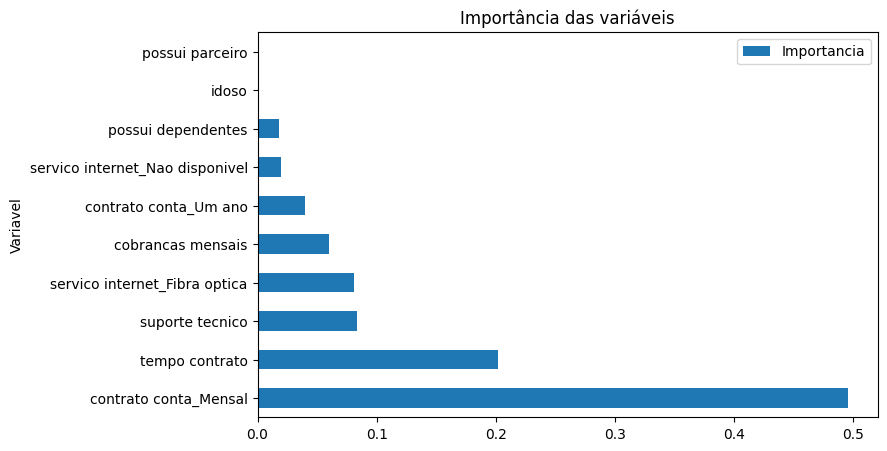

In [60]:
importancias.head(10).plot(
    x='Variavel',
    y='Importancia',
    kind='barh',
    figsize=(8,5),
    title='Importância das variáveis'
);

##### **08.4 Visualização folhas :do Modelo Árvore de Decisão**

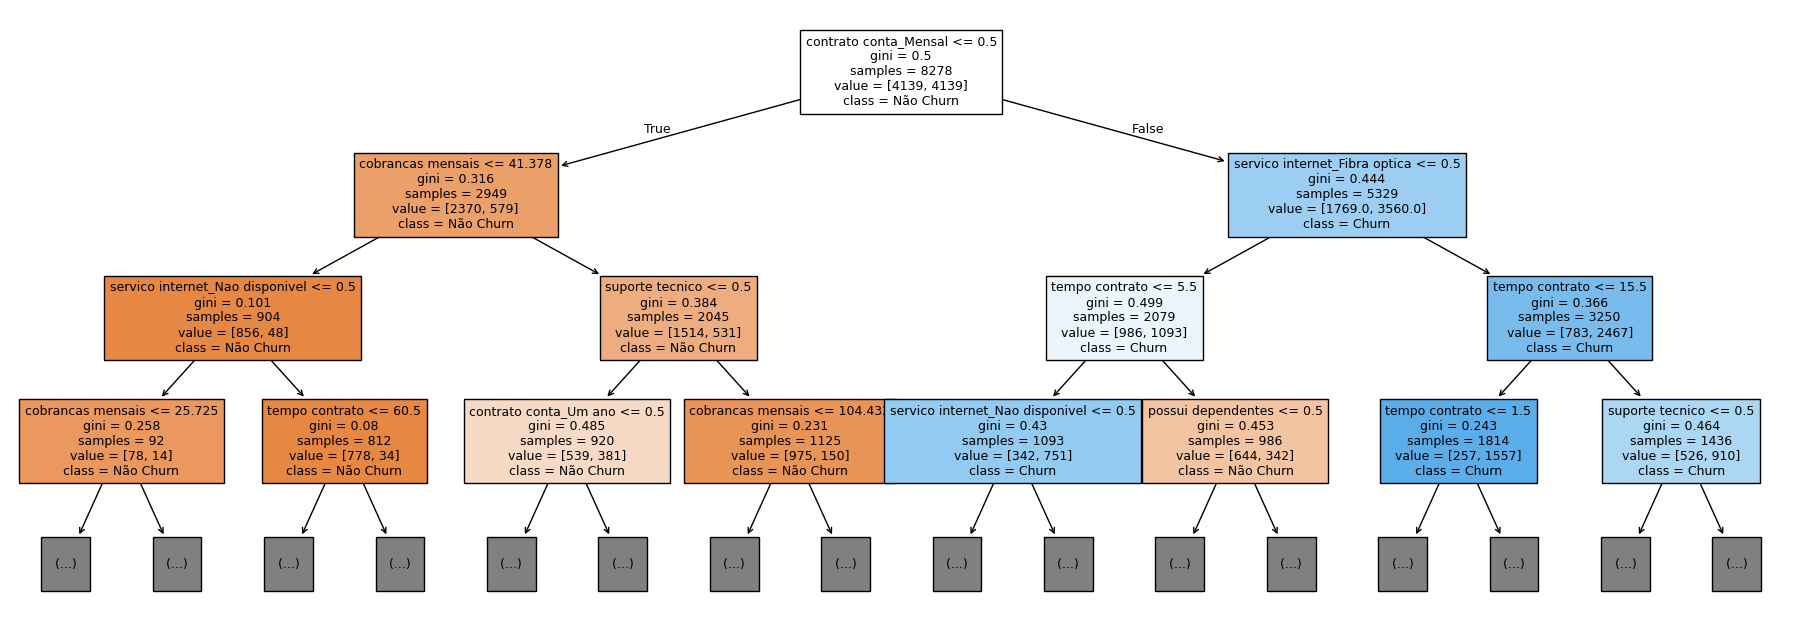

In [55]:
plt.figure(figsize=(23,8))
plot_tree(
    pipeline_tree.named_steps['modelo'],
    feature_names=x_treino.columns,
    class_names=['Não Churn','Churn'],
    filled=True,
    max_depth=3,
    fontsize=9
);

##### **09. Treinamento Floresta Randomica**

In [85]:
pipeline_rf = Pipeline(steps=[
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        max_depth=None,
        min_samples_split=5,
        min_samples_leaf=2,
        random_state=42,
        n_jobs=-1
    ))
])

In [86]:
pipeline_rf.fit(x_treino, y_treino)

Pipeline(steps=[('smote', SMOTE(random_state=42)),
                ('rf',
                 RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                                        n_estimators=300, n_jobs=-1,
                                        random_state=42))])

##### **09.2 Avaliando Modelo Floresta Randomica**





In [91]:
y_proba_rf = pipeline_rf.predict_proba(x_teste)[:,1]

threshold = 0.35  # teste 0.40 ou 0.35
y_pred_custom = (y_proba_rf >= threshold).astype(int)

print(confusion_matrix(y_teste, y_pred_custom))
print(classification_report(y_teste, y_pred_custom))
print("AUC:", roc_auc_score(y_teste, y_proba_rf))

[[715 320]
 [ 85 289]]
              precision    recall  f1-score   support

           0       0.89      0.69      0.78      1035
           1       0.47      0.77      0.59       374

    accuracy                           0.71      1409
   macro avg       0.68      0.73      0.68      1409
weighted avg       0.78      0.71      0.73      1409

AUC: 0.8073742540494457


##### **09.3 Análise de importância das variáveis**

In [92]:
importancias_rf = pd.DataFrame({
    'Variavel': x_treino.columns,
    'Importancia': pipeline_rf.named_steps['rf'].feature_importances_
}).sort_values(by='Importancia', ascending=False)

importancias_rf.head(10)

,Variavel,Importancia
6,cobrancas mensais,0.283815
3,tempo contrato,0.275830
9,contrato conta_Mensal,0.129615
5,suporte tecnico,0.066263
7,servico internet_Fibra optica,0.062670
10,contrato conta_Um ano,0.040685
1,possui parceiro,0.039788
8,servico internet_Nao disponivel,0.038641
2,possui dependentes,0.035253
4,multiplas linhas,0.015842


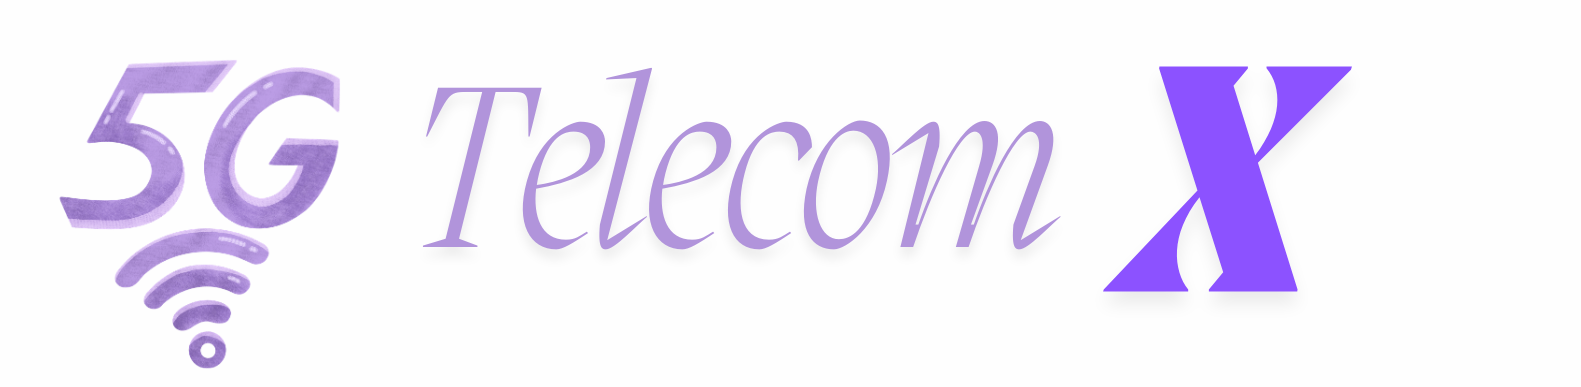

# **Relatório de Análise Preditiva – Evasão de Clientes (Churn)**


**Data:** 25/02/2026

**Empresa:** Telecom X

**Responsável:** [Fernando do Valle](http://linkedin.com/in/fernando-do-valle/)


## **Objetivo do Projeto**

O objetivo deste estudo foi identificar os principais fatores que influenciam a evasão de clientes (churn) na empresa TelecomX, utilizando técnicas de Machine Learning para:



- Prever a probabilidade de evasão

- Identificar variáveis mais relevantes

- Comparar o desempenho de diferentes modelos

- Propor estratégias de retenção baseadas em dados


## **Perguntas a Serem Respondidas por Esta Análise**



*   Quem são os clientes com maior risco de evasão?
*   Quais variáveis mais influenciam esse comportameto?
*   Que tipo de perfil a empresa precisa manter mais próximo?



## **Detalhamento Técnico**

### Modelos Estatísticos Utilizados

Foram treinados e avaliados três modelos de classificação:

1. Regressão Logística

2. Árvore de Decisão

3. SVM (Support Vector Machine)

O modelo com melhor desempenho foi a regressao logística.

A divisão dos dados foi feita com:

80% treino

20% teste

Estratificação da variável alvo

## **Avaliação dos Modelos**

### **Regressão Logística**

Acurácia: 78,7%


In [82]:
cm = confusion_matrix(y_teste, y_pred)
print(cm)

[[736 299]
 [ 84 290]]


Principais métricas para churn (classe 1):

- Precisão: 62%

- Recall: 49%

- F1-score: 55%

#### **Interpretação:**

O modelo apresenta boa capacidade geral de classificação, mas identifica apenas 49% dos clientes que realmente evadem, o que indica espaço para melhoria na detecção de churn.

### **Árvore de decisão**

Acurácia: 79,4%

In [83]:
cm_arvore = confusion_matrix(y_teste, y_pred)
print(cm_arvore)

[[736 299]
 [ 84 290]]


Principais métricas para churn (classe 1):

- Precisão: 70%

- Recall: 39%

- F1-score: 50%

#### **Interpretação:**

A árvore apresentou levemente melhor acurácia, porém recall inferior na classe de evasão, indicando maior dificuldade em capturar clientes que realmente cancelam.

### **SVM (Support Vector Machine)**

O modelo SVM apresentou resultados idênticos à Árvore de Decisão na execução registrada, indicando possível reutilização de variável de predição no código.
Recomenda-se revisar a variável y_pred utilizada na avaliação.

## **Principais Fatores que Influenciam a Evasão**

A análise foi feita utilizando:

- Coeficientes da Regressão Logística

- Importância das variáveis na Árvore de Decisão

### Variáveis mais relevantes (Regressão Logística)

In [84]:
plotar_coeficientes(coeficientes, x_treino.columns)

NameError: name 'plotar_coeficientes' is not defined

### Variáveis mais relevantes (árvore de decisão)

1. Contrato mensal (61% da importância total)

2. Tempo de contrato

3. Internet Fibra Óptica

4. Cobrança mensal

## **Principais Insights Estratégicos**

### 1. Tipo de contrato é o fator mais determinante

Clientes com contrato mensal têm probabilidade significativamente maior de evasão.

Clientes com contrato de dois anos apresentam risco muito menor.

### 2. Tempo de relacionamento reduz churn

Quanto maior o tempo de contrato, menor a probabilidade de evasão.

Isso indica que fidelização ao longo do tempo é um fator protetor.

### 3. Valor da mensalidade influencia fortemente

- Cobranças mensais elevadas aumentam o risco.

- Excedentes de cobrança também impactam negativamente.

- Preço diário elevado está associado à saída.

### 4. Internet Fibra Óptica apresenta maior evasão

Pode indicar:

- Expectativa não atendida

- Problemas de qualidade

- Alta competitividade nesse segmento

### 5. Suporte técnico reduz evasão

Clientes que utilizam ou possuem suporte técnico apresentam menor probabilidade de churn.

### 6.Estratégias de Retenção Propostas

Com base nos resultados, recomenda-se:

1. Incentivar migração para contratos longos

- Oferecer desconto para migração de contrato mensal para anual/bienal

- Criar benefícios exclusivos para contratos longos

2. Programa de retenção nos primeiros meses

Clientes com pouco tempo de contrato são mais vulneráveis.

___

Ações:

- Onboarding estruturado

- Contato proativo nos primeiros 90 dias

- Ofertas personalizadas

___

3. Revisão da política de cobrança

- Reduzir impacto de excedentes

- Oferecer planos mais ajustados ao perfil de consumo

- Alertas preventivos de ultrapassagem

___


4. Monitoramento do serviço de fibra óptica

- Avaliar qualidade do serviço

- Investigar reclamações

- Melhorar experiência do cliente

___

5. Fortalecer suporte técnico

- Tornar suporte mais acessível

- Atendimento proativo para clientes de alto risco

- Uso do modelo para identificar clientes propensos à evasão e acionar suporte antecipadamente

## **7. Conclusão Executiva**

O estudo identificou que o tipo de contrato, o tempo de relacionamento e o valor das cobranças mensais são os principais fatores que influenciam a evasão na TelecomX.

Embora os modelos apresentem acurácia próxima de 79%, ainda existe dificuldade na identificação completa dos clientes que irão cancelar (recall abaixo de 50% na maioria dos casos).

A Regressão Logística demonstrou melhor equilíbrio interpretativo e explicativo, sendo recomendada como modelo base para decisões estratégicas, principalmente pela clareza na interpretação dos coeficientes.

A implementação das estratégias propostas pode reduzir significativamente a evasão e aumentar o lifetime value dos clientes.